# Evaluation Code for KSQL and ML
Before evaluating, please run KSQL infrastructure with `test.pcap` generated from `../datasets/preparation2.py`, then run `../rule-detection/evaluation/consumer/script.py` to consume the results from Kafka, and lastly run `../rule-detection/evaluation/ksql_evaluation_dos.py` and `../rule-detection/evaluation/ksql_evaluation_ps.py` to find list of packets in the pcap (in the form of index) that is malicious/detected.

**Metrics**
- Accuracy, Precision, Recall, F1-Score
- Inference Time for ML

In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import joblib
import time

In [30]:
MODEL_LOCATION = "../ai-detection/notebooks/models2/postfs"

## Post-Processing for KSQL Predictions

In [ ]:
# Get PCAP Indexes of all flows
# For example, if 125th, 126th, and 127th is part of k-th flow (in whole dataset train & test), then flow_packets[k] = [125, 126, 127]
flow_packets = []
with open("../datasets/output/pcap_indexes_run_index.txt") as file:
    for line in file:
        indexes = line.strip().split(",")
        if len(indexes[-1]) == 0:
            indexes = indexes[:-1]
        indexes = [int(x) for x in indexes]
        flow_packets.append(indexes)

In [ ]:
# Creating mapping to convert whole dataset PCAP indexes to test dataset PCAP indexes
full_to_test_mapping = {}
with open("../datasets/output/test_pcap_index_mapping.txt") as file:
    for line in file:
        before, after = line.strip().split(",")
        before = int(before)
        after = int(after)
        assert before not in full_to_test_mapping
        full_to_test_mapping[before] = after

In [ ]:
# Convert using mapping
test_flow_packets = []
for cur_packets in flow_packets:
    new_packets = []
    is_in_test = True

    debug_partial = False
    for idx in cur_packets:
        if idx not in full_to_test_mapping:
            is_in_test = False
            assert not debug_partial # if assertion error, there may be problem in your dataset preparation
            break
        debug_partial = True
        new_packets.append(full_to_test_mapping[idx])
    if is_in_test:
        test_flow_packets.append(new_packets)
    else:
        test_flow_packets.append(None)

In [ ]:
test_flow_packets_set = [set(i) if i is not None else None for i in test_flow_packets]

In [9]:
np_test_flow_packets_set = pd.Series(np.array(test_flow_packets_set))
flow_packets_set_test_only = np_test_flow_packets_set[~np_test_flow_packets_set.isna()]

In [12]:
with open("../rule-detection/evaluation/detected_ksql_2_slowloris.txt") as file:
    detected_dos_idxs = [int(x.strip()) for x in file.readlines()]
detected_dos_idx_set = set(detected_dos_idxs)

with open("../rule-detection/evaluation/detected_ksql_2_portscan.txt") as file:
    detected_portscan_idxs = [int(x.strip()) for x in file.readlines()]
detected_portscan_idx_set = set(detected_portscan_idxs)

In [13]:
is_detected_dos = np.array([len(detected_dos_idx_set.intersection(flow_packet_set)) > 0 for flow_packet_set in flow_packets_set_test_only.values])
is_detected_dos = pd.Series(is_detected_dos)

is_detected_portscan = np.array([len(detected_portscan_idx_set.intersection(flow_packet_set)) > 0 for flow_packet_set in flow_packets_set_test_only.values])
is_detected_portscan = pd.Series(is_detected_portscan)

In [14]:
is_detected_dos.index = flow_packets_set_test_only.index
is_detected_portscan.index = flow_packets_set_test_only.index

In [17]:
# Load Test Dataset
flink_test = pd.read_csv('../datasets/output/test_final.csv', index_col=0)

In [18]:
assert set(flink_test['Old Index'].values).issubset(set(is_detected_dos.index))
assert set(flink_test['Old Index'].values).issubset(set(is_detected_portscan.index))

In [19]:
is_detected_dos_df = pd.DataFrame(is_detected_dos, columns=['Binary Prediction']).reset_index().rename(columns={'index': 'Old Index'})
is_detected_dos_df['Binary Prediction'] = np.where(is_detected_dos_df['Binary Prediction'], 'Slowloris', 'Not Slowloris')

is_detected_ps_df = pd.DataFrame(is_detected_portscan, columns=['Binary Prediction']).reset_index().rename(columns={'index': 'Old Index'})
is_detected_ps_df['Binary Prediction'] = np.where(is_detected_ps_df['Binary Prediction'], 'PortScan', 'Not PortScan')

In [20]:
flink_test_binary_dos = flink_test.merge(is_detected_dos_df, on=['Old Index'], how='left', indicator=True)
flink_test_binary_ps = flink_test.merge(is_detected_ps_df, on=['Old Index'], how='left', indicator=True)

In [23]:
flink_test_binary_dos["_merge"].value_counts()

_merge
both          153698
left_only          0
right_only         0
Name: count, dtype: int64

In [22]:
flink_test_binary_ps["_merge"].value_counts()

_merge
both          153698
left_only          0
right_only         0
Name: count, dtype: int64

In [24]:
flink_test_binary_dos['Binary Label'] = np.where(flink_test_binary_dos['Label'] == 'Slowloris', 'Slowloris', 'Not Slowloris')
flink_test_binary_ps['Binary Label'] = np.where(flink_test_binary_ps['Label'] == 'Portscan', 'PortScan', 'Not PortScan')

In [25]:
y_true_dos = flink_test_binary_dos['Binary Label']
y_pred_ksql_dos = flink_test_binary_dos['Binary Prediction']

y_true_ps = flink_test_binary_ps['Binary Label']
y_pred_ksql_ps = flink_test_binary_ps['Binary Prediction']

# Model Preparation

In [31]:
dt = joblib.load(f"{MODEL_LOCATION}/dt.pkl")
rf = joblib.load(f"{MODEL_LOCATION}/rf.pkl")
et = joblib.load(f"{MODEL_LOCATION}/et.pkl")
xg = joblib.load(f"{MODEL_LOCATION}/xg.pkl")
lgbm = joblib.load(f"{MODEL_LOCATION}/lgbm.pkl")
cat = joblib.load(f"{MODEL_LOCATION}/cat.pkl")
stk1 = joblib.load(f"{MODEL_LOCATION}/stk1.pkl")
stk2 = joblib.load(f"{MODEL_LOCATION}/stk2.pkl")
stk3 = joblib.load(f"{MODEL_LOCATION}/stk3.pkl")

In [36]:
fs = ['Fwd Seg Size Min', 'Bwd RST Flags', 'Flow Duration', 'Bwd Segment Size Avg', 'Bwd Act Data Pkts', 'Protocol', 'Bwd Packet Length Max', 'Flow IAT Max', 'Fwd IAT Min', 'Bwd Packet Length Mean', 'Fwd IAT Total', 'RST Flag Count', 'Average Packet Size', 'Bwd Init Win Bytes', 'FWD Init Win Bytes', 'Total Length of Bwd Packet', 'Packet Length Mean', 'Fwd IAT Max', 'FIN Flag Count', 'Down/Up Ratio', 'Fwd Packet Length Max', 'Flow IAT Mean', 'Packet Length Max', 'Fwd IAT Mean', 'Fwd Packets/s', 'Flow IAT Min', 'SYN Flag Count', 'Total Length of Fwd Packet', 'Fwd Packet Length Mean', 'Packet Length Std', 'Bwd IAT Min', 'ACK Flag Count', 'Idle Max', 'Bwd IAT Mean', 'Flow IAT Std', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packet Length Min', 'Bwd Packets/s', 'Bwd Packet Length Std', 'Fwd IAT Std', 'Fwd Bulk Rate Avg', 'Total Bwd packets', 'Subflow Fwd Packets', 'Bwd IAT Max']

In [56]:
top_3_models = ['et', 'rf', 'cat']

In [37]:
labelencoder = LabelEncoder()
labelencoder.fit_transform(['Benign', 'Portscan', 'Slowloris'])

array([0, 1, 2])

In [38]:
X_test_fs = flink_test[fs]
y_test = labelencoder.transform(flink_test['Label'])

## Accuracy, Precision, Recall, F1-Score

### DoS

#### KSQL

Accuracy of KSQL: 0.7858397636924358
Precision of KSQL: 0.4953330052493438
Recall of KSQL: 0.3958508127949659
F1-score of KSQL: 0.44003934712911685
               precision    recall  f1-score   support

Not Slowloris    0.99067   0.79170   0.88008    152560
    Slowloris    0.00000   0.00000   0.00000      1138

     accuracy                        0.78584    153698
    macro avg    0.49533   0.39585   0.44004    153698
 weighted avg    0.98333   0.78584   0.87356    153698



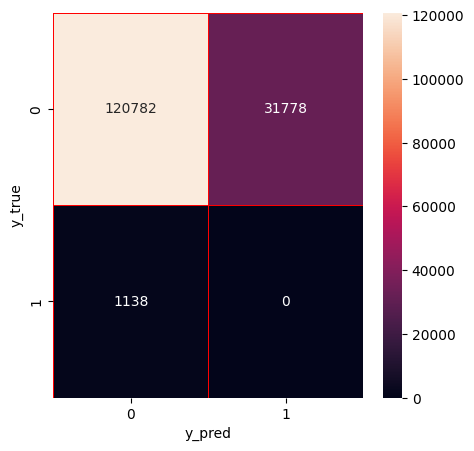

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,precision_recall_fscore_support, accuracy_score

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_pred_ksql_dos, average='macro')

# Print results
print('Accuracy of KSQL: ' + str(accuracy_score(y_true_dos, y_pred_ksql_dos)))
print('Precision of KSQL: ' + str(precision))
print('Recall of KSQL: ' + str(recall))
print('F1-score of KSQL: ' + str(fscore))
print(classification_report(y_true_dos, y_pred_ksql_dos, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_pred_ksql_dos)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Machine Learning

Prediction time per sample:  0.00018304952574724968
Accuracy of DT: 0.9975731629559266
Precision of DT: 0.9918277407416662
Recall of DT: 0.8409129820022985
F1-score of DT: 0.9025063505295017
               precision    recall  f1-score   support

Not Slowloris    0.99763   0.99993   0.99878    152560
    Slowloris    0.98602   0.68190   0.80623      1138

     accuracy                        0.99757    153698
    macro avg    0.99183   0.84091   0.90251    153698
 weighted avg    0.99755   0.99757   0.99735    153698



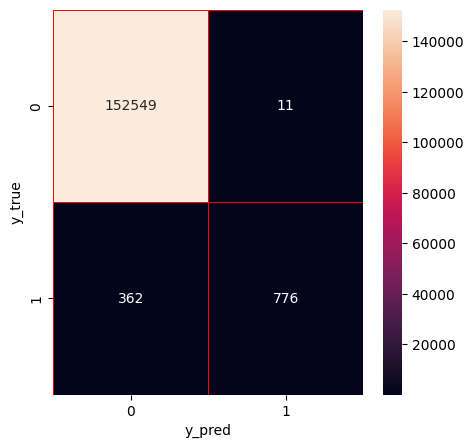

In [68]:
# Decision Tree
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_test_fs)
end = time.time()

predict_time_dt = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_dt)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of DT: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.002227154787482526
Accuracy of RF: 0.9973649624588479
Precision of RF: 0.9979991470971082
Recall of RF: 0.8224923289278332
F1-score of RF: 0.8912218790979582
               precision    recall  f1-score   support

Not Slowloris    0.99736   0.99999   0.99867    152560
    Slowloris    0.99864   0.64499   0.78377      1138

     accuracy                        0.99736    153698
    macro avg    0.99800   0.82249   0.89122    153698
 weighted avg    0.99737   0.99736   0.99708    153698



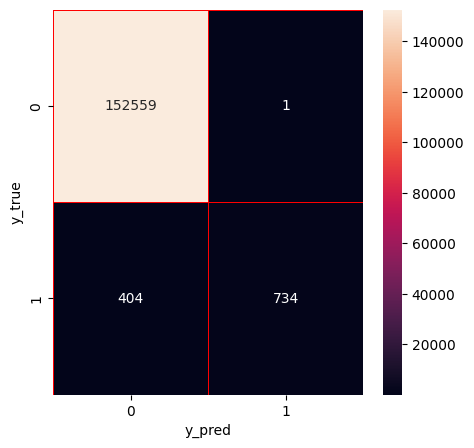

In [69]:
# Random Forest
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_test_fs)
end = time.time()

predict_time_rf = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_rf)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of RF: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0035475269242126236
Accuracy of ET: 0.9976902757355334
Precision of ET: 0.9982055363815593
Recall of ET: 0.844460694481436
F1-score of ET: 0.9071152417679138
               precision    recall  f1-score   support

Not Slowloris    0.99768   0.99999   0.99884    152560
    Slowloris    0.99873   0.68893   0.81539      1138

     accuracy                        0.99769    153698
    macro avg    0.99821   0.84446   0.90712    153698
 weighted avg    0.99769   0.99769   0.99748    153698



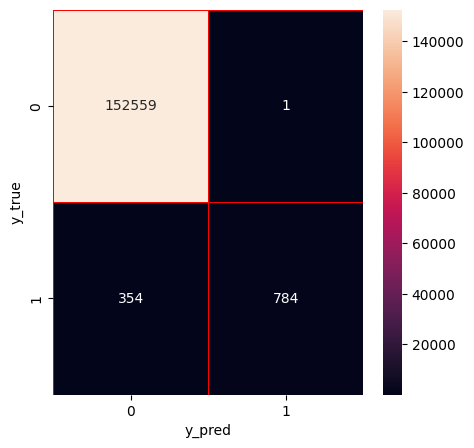

In [70]:
# Extra Trees
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_test_fs)
end = time.time()

predict_time_et = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_et)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of ET: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0005222955015815118
Accuracy of XG: 0.9976772632044659
Precision of XG: 0.9988327000922068
Recall of XG: 0.8431458699472759
F1-score of XG: 0.9063984714988739
               precision    recall  f1-score   support

Not Slowloris    0.99767   1.00000   0.99883    152560
    Slowloris    1.00000   0.68629   0.81397      1138

     accuracy                        0.99768    153698
    macro avg    0.99883   0.84315   0.90640    153698
 weighted avg    0.99768   0.99768   0.99746    153698



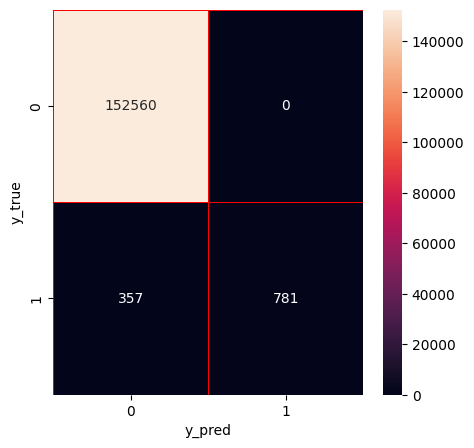

In [71]:
# XGBoost
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_test_fs)
end = time.time()

predict_time_xg = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_xg)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of XG: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of XG: ' + str(precision))
print('Recall of XG: ' + str(recall))
print('F1-score of XG: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0010428893207645902
Accuracy of LGBM: 0.9978204010462075
Precision of LGBM: 0.9989044769286111
Recall of LGBM: 0.8528119507908611
F1-score of LGBM: 0.9131559138670935
               precision    recall  f1-score   support

Not Slowloris    0.99781   1.00000   0.99890    152560
    Slowloris    1.00000   0.70562   0.82741      1138

     accuracy                        0.99782    153698
    macro avg    0.99890   0.85281   0.91316    153698
 weighted avg    0.99783   0.99782   0.99763    153698



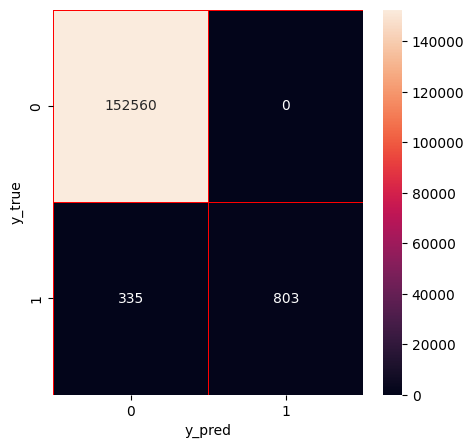

In [72]:
# LightGBM
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_test_fs)
end = time.time()

predict_time_lgbm = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_lgbm)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of LGBM: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of LGBM: ' + str(precision))
print('Recall of LGBM: ' + str(recall))
print('F1-score of LGBM: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0002561334496486083


/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of Cat: 0.9977748571874715
Precision of Cat: 0.9988816366038378
Recall of Cat: 0.8497363796133568
F1-score of Cat: 0.9110224052633935
               precision    recall  f1-score   support

Not Slowloris    0.99776   1.00000   0.99888    152560
    Slowloris    1.00000   0.69947   0.82316      1138

     accuracy                        0.99777    153698
    macro avg    0.99888   0.84974   0.91102    153698
 weighted avg    0.99778   0.99777   0.99758    153698



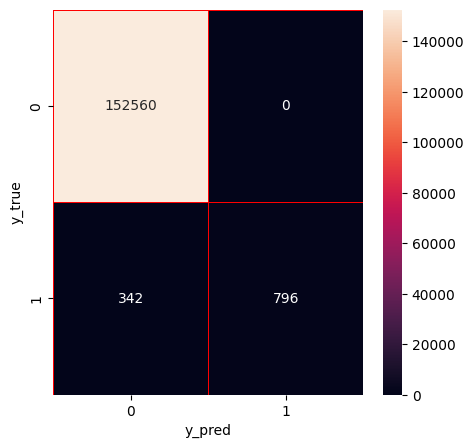

In [63]:
# CatBoost
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of Cat: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of Cat: ' + str(precision))
print('Recall of Cat: ' + str(recall))
print('F1-score of Cat: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [57]:
top_3_models

['et', 'rf', 'cat']

Prediction time per sample:  0.00641508048682919
Accuracy of STK Traditional: 0.9977748571874715
Precision of STK Traditional: 0.9988816366038378
Recall of STK Traditional: 0.8497363796133568
F1-score of STK Traditional: 0.9110224052633935
               precision    recall  f1-score   support

Not Slowloris    0.99776   1.00000   0.99888    152560
    Slowloris    1.00000   0.69947   0.82316      1138

     accuracy                        0.99777    153698
    macro avg    0.99888   0.84974   0.91102    153698
 weighted avg    0.99778   0.99777   0.99758    153698



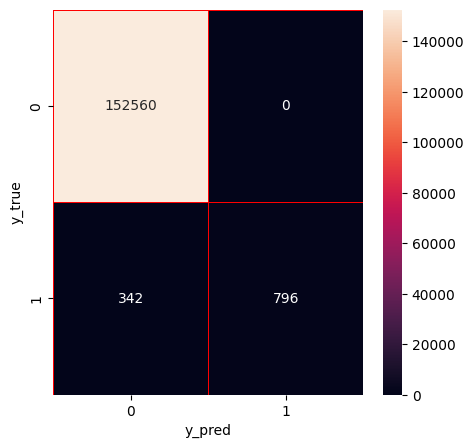

In [65]:
# Ensemble method 1: traditional stacking

# !!! WARNING: always update based used models below based on top_3_models in training !!!
start = time.time()
et_test = et.predict(X_test_fs)
rf_test = rf.predict(X_test_fs)
cat_test = cat.predict(X_test_fs)

et_test = et_test.reshape(-1, 1)
rf_test = rf_test.reshape(-1, 1)
cat_test = cat_test.reshape(-1, 1)

x_test = np.concatenate([et_test, rf_test, cat_test], axis=1)

y_predict = stk1.predict(x_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of STK Traditional: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of STK Traditional: ' + str(precision))
print('Recall of STK Traditional: ' + str(recall))
print('F1-score of STK Traditional: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.007166522957944866
Accuracy of STK Confidence: 0.9978594386394097
Precision of STK Confidence: 0.9977005564280059
Recall of STK Confidence: 0.8563203344813254
F1-score of STK Confidence: 0.9151457059831343
               precision    recall  f1-score   support

Not Slowloris    0.99786   0.99999   0.99892    152560
    Slowloris    0.99754   0.71265   0.83137      1138

     accuracy                        0.99786    153698
    macro avg    0.99770   0.85632   0.91515    153698
 weighted avg    0.99786   0.99786   0.99768    153698



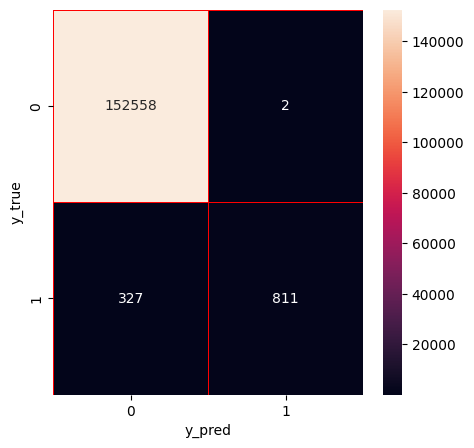

In [66]:
# Ensemble method 2: confidence-based stacking

# !!! WARNING: always update based used models below based on top_3_models in training !!!
start = time.time()
et_prob_test = et.predict_proba(X_test_fs)
rf_prob_test = rf.predict_proba(X_test_fs)
cat_prob_test = cat.predict_proba(X_test_fs)

x_test = np.concatenate([et_prob_test, rf_prob_test, cat_prob_test], axis=1)

y_predict = stk2.predict(x_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of STK Confidence: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of STK Confidence: ' + str(precision))
print('Recall of STK Confidence: ' + str(recall))
print('F1-score of STK Confidence: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.012556736135044103
Accuracy of STK Hybrid: 0.9977748571874715
Precision of STK Hybrid: 0.9988816366038378
Recall of STK Hybrid: 0.8497363796133568
F1-score of STK Hybrid: 0.9110224052633935
               precision    recall  f1-score   support

Not Slowloris    0.99776   1.00000   0.99888    152560
    Slowloris    1.00000   0.69947   0.82316      1138

     accuracy                        0.99777    153698
    macro avg    0.99888   0.84974   0.91102    153698
 weighted avg    0.99778   0.99777   0.99758    153698



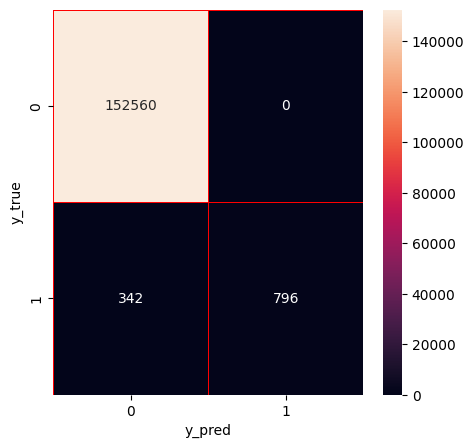

In [67]:
# Ensemble method 3: hybrid stacking

# !!! WARNING: always update based used models below based on top_3_models in training !!!
start = time.time()

et_test = et.predict(X_test_fs)
rf_test = rf.predict(X_test_fs)
cat_test = cat.predict(X_test_fs)

et_prob_test = et.predict_proba(X_test_fs)
rf_prob_test = rf.predict_proba(X_test_fs)
cat_prob_test = cat.predict_proba(X_test_fs)

et_test = et_test.reshape(-1, 1)
rf_test = rf_test.reshape(-1, 1)
cat_test = cat_test.reshape(-1, 1)

x_test = np.concatenate([et_test, rf_test, cat_test] + [et_prob_test, rf_prob_test, cat_prob_test], axis=1)

y_predict = stk3.predict(x_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Slowloris', 'Slowloris', 'Not Slowloris')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_dos, y_predict, average='macro')

# Print results
print('Accuracy of STK Hybrid: ' + str(accuracy_score(y_true_dos, y_predict)))
print('Precision of STK Hybrid: ' + str(precision))
print('Recall of STK Hybrid: ' + str(recall))
print('F1-score of STK Hybrid: ' + str(fscore))
print(classification_report(y_true_dos, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_dos, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

### Port Scan

#### KSQL

Accuracy of KSQL: 0.9881390779320486
Precision of KSQL: 0.9887786585421366
Recall of KSQL: 0.9881390779320486
F1-score of KSQL: 0.9882592258120892
              precision    recall  f1-score   support

Not PortScan    0.99998   0.98507   0.99247    121890
    PortScan    0.94587   0.99991   0.97214     31808

    accuracy                        0.98814    153698
   macro avg    0.97292   0.99249   0.98230    153698
weighted avg    0.98878   0.98814   0.98826    153698



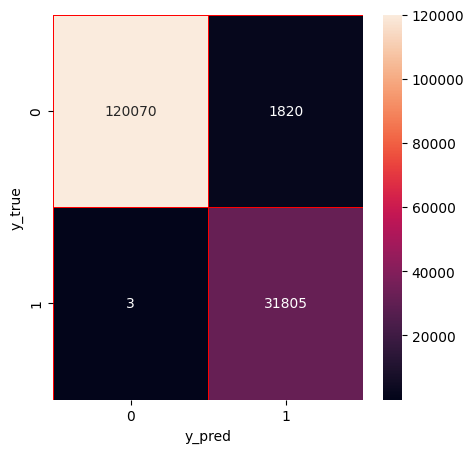

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix,precision_recall_fscore_support, accuracy_score

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_pred_ksql_ps, average='weighted')

# Print results
print('Accuracy of KSQL: ' + str(accuracy_score(y_true_ps, y_pred_ksql_ps)))
print('Precision of KSQL: ' + str(precision))
print('Recall of KSQL: ' + str(recall))
print('F1-score of KSQL: ' + str(fscore))
print(classification_report(y_true_ps, y_pred_ksql_ps, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_pred_ksql_ps)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

#### Machine Learning

Prediction time per sample:  0.00016193284161792094
Accuracy of DT: 0.999486005022837
Precision of DT: 0.999652822734009
Recall of DT: 0.9987814085575888
F1-score of DT: 0.9992163726281488
              precision    recall  f1-score   support

Not PortScan    0.99937   0.99998   0.99968    121890
    PortScan    0.99994   0.99758   0.99876     31808

    accuracy                        0.99949    153698
   macro avg    0.99965   0.99878   0.99922    153698
weighted avg    0.99949   0.99949   0.99949    153698



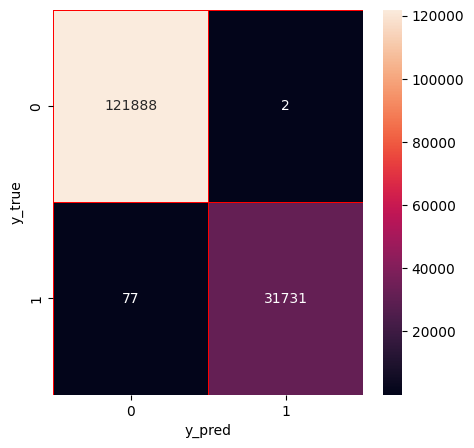

In [73]:
# Decision Tree
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = dt.predict(X_test_fs)
end = time.time()

predict_time_dt = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_dt)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'PortScan', 'Not PortScan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of DT: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of DT: ' + str(precision))
print('Recall of DT: ' + str(recall))
print('F1-score of DT: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0020960073504947864
Accuracy of RF: 0.9995835990058426
Precision of RF: 0.9997376059825835
Recall of RF: 0.9989939637826961
F1-score of RF: 0.9993652438842373
              precision    recall  f1-score   support

Not PortScan    0.99948   1.00000   0.99974    121890
    PortScan    1.00000   0.99799   0.99899     31808

    accuracy                        0.99958    153698
   macro avg    0.99974   0.99899   0.99937    153698
weighted avg    0.99958   0.99958   0.99958    153698



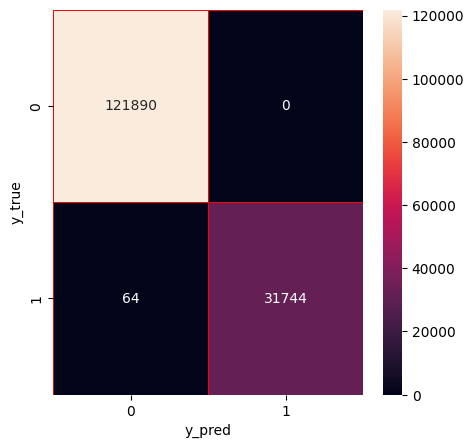

In [74]:
# Random Forest
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = rf.predict(X_test_fs)
end = time.time()

predict_time_rf = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_rf)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'PortScan', 'Not PortScan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of RF: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of RF: ' + str(precision))
print('Recall of RF: ' + str(recall))
print('F1-score of RF: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.00382400610434241
Accuracy of ET: 0.99959661153691
Precision of ET: 0.9997458016268697
Recall of ET: 0.9990254024144869
F1-score of ET: 0.9993850943205225
              precision    recall  f1-score   support

Not PortScan    0.99949   1.00000   0.99975    121890
    PortScan    1.00000   0.99805   0.99902     31808

    accuracy                        0.99960    153698
   macro avg    0.99975   0.99903   0.99939    153698
weighted avg    0.99960   0.99960   0.99960    153698



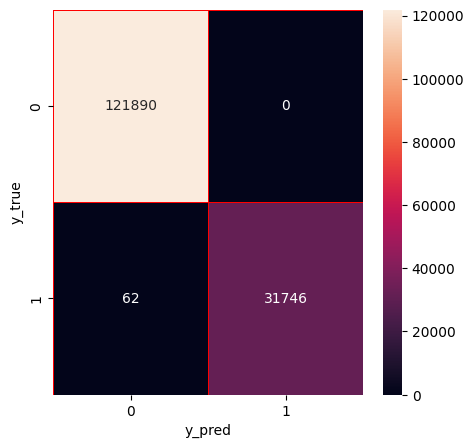

In [75]:
# Extra Trees
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = et.predict(X_test_fs)
end = time.time()

predict_time_et = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_et)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'PortScan', 'Not PortScan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of ET: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of ET: ' + str(precision))
print('Recall of ET: ' + str(recall))
print('F1-score of ET: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0005638525402816305
Accuracy of XG: 0.99959661153691
Precision of XG: 0.9997458016268697
Recall of XG: 0.9990254024144869
F1-score of XG: 0.9993850943205225
              precision    recall  f1-score   support

Not PortScan    0.99949   1.00000   0.99975    121890
    PortScan    1.00000   0.99805   0.99902     31808

    accuracy                        0.99960    153698
   macro avg    0.99975   0.99903   0.99939    153698
weighted avg    0.99960   0.99960   0.99960    153698



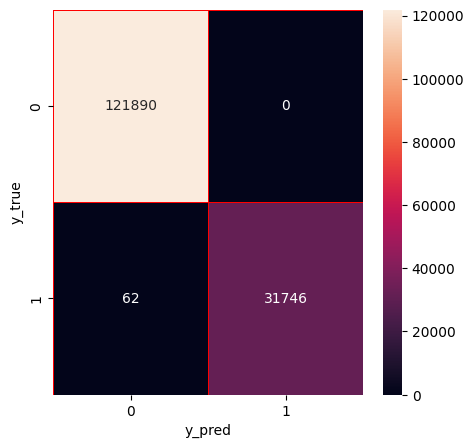

In [76]:
# XGBoost
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = xg.predict(X_test_fs)
end = time.time()

predict_time_xg = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_xg)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'PortScan', 'Not PortScan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of XG: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of XG: ' + str(precision))
print('Recall of XG: ' + str(recall))
print('F1-score of XG: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.0010248393878674426
Accuracy of LGBM: 0.99959661153691
Precision of LGBM: 0.9997458016268697
Recall of LGBM: 0.9990254024144869
F1-score of LGBM: 0.9993850943205225
              precision    recall  f1-score   support

Not PortScan    0.99949   1.00000   0.99975    121890
    PortScan    1.00000   0.99805   0.99902     31808

    accuracy                        0.99960    153698
   macro avg    0.99975   0.99903   0.99939    153698
weighted avg    0.99960   0.99960   0.99960    153698



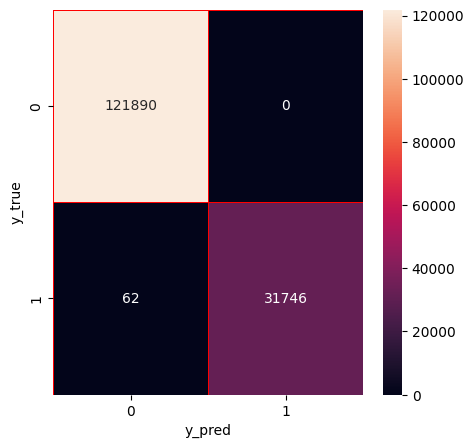

In [77]:
# LightGBM
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = lgbm.predict(X_test_fs)
end = time.time()

predict_time_lgbm = (end - start) / len(X_test_fs) * 1000
print('Prediction time per sample: ', predict_time_lgbm)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'PortScan', 'Not PortScan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of LGBM: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of LGBM: ' + str(precision))
print('Recall of LGBM: ' + str(recall))
print('F1-score of LGBM: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.00032951365553547353


/home/meervix/Projects/thesis/intrusion-detection/ai-detection/venv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy of Cat: 0.9995901052713764
Precision of Cat: 0.9997417037711249
Recall of Cat: 0.9990096830985915
F1-score of Cat: 0.9993751692178892
              precision    recall  f1-score   support

Not PortScan    0.99948   1.00000   0.99974    121890
    PortScan    1.00000   0.99802   0.99901     31808

    accuracy                        0.99959    153698
   macro avg    0.99974   0.99901   0.99938    153698
weighted avg    0.99959   0.99959   0.99959    153698



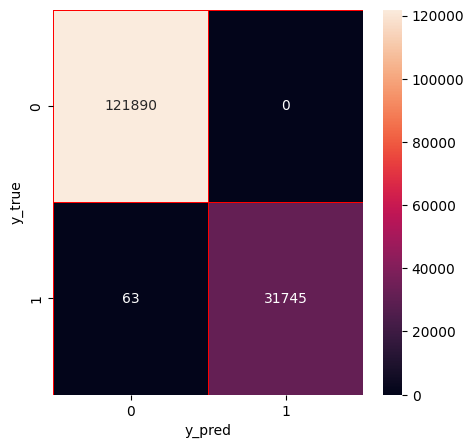

In [78]:
# CatBoost
# calculate the prediction time per sample in milliseconds
start = time.time()
y_predict = cat.predict(X_test_fs)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'PortScan', 'Not PortScan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of Cat: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of Cat: ' + str(precision))
print('Recall of Cat: ' + str(recall))
print('F1-score of Cat: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [79]:
top_3_models

['et', 'rf', 'cat']

Prediction time per sample:  0.006767867014765481
Accuracy of STK Traditional: 0.9995901052713764
Precision of STK Traditional: 0.9997417037711249
Recall of STK Traditional: 0.9990096830985915
F1-score of STK Traditional: 0.9993751692178892
              precision    recall  f1-score   support

Not PortScan    0.99948   1.00000   0.99974    121890
    PortScan    1.00000   0.99802   0.99901     31808

    accuracy                        0.99959    153698
   macro avg    0.99974   0.99901   0.99938    153698
weighted avg    0.99959   0.99959   0.99959    153698



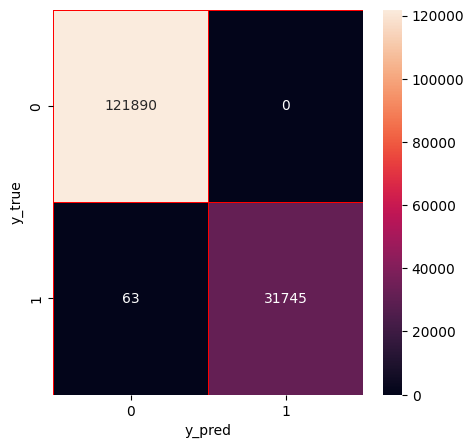

In [80]:
# Ensemble method 1: traditional stacking

# !!! WARNING: always update based used models below based on top_3_models in training !!!
start = time.time()
et_test = et.predict(X_test_fs)
rf_test = rf.predict(X_test_fs)
cat_test = cat.predict(X_test_fs)

et_test = et_test.reshape(-1, 1)
rf_test = rf_test.reshape(-1, 1)
cat_test = cat_test.reshape(-1, 1)

x_test = np.concatenate([et_test, rf_test, cat_test], axis=1)

y_predict = stk1.predict(x_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'PortScan', 'Not PortScan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of STK Traditional: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of STK Traditional: ' + str(precision))
print('Recall of STK Traditional: ' + str(recall))
print('F1-score of STK Traditional: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.007022123494767685
Accuracy of STK Confidence: 0.9995835990058426
Precision of STK Confidence: 0.9997376059825835
Recall of STK Confidence: 0.9989939637826961
F1-score of STK Confidence: 0.9993652438842373
              precision    recall  f1-score   support

Not PortScan    0.99948   1.00000   0.99974    121890
    PortScan    1.00000   0.99799   0.99899     31808

    accuracy                        0.99958    153698
   macro avg    0.99974   0.99899   0.99937    153698
weighted avg    0.99958   0.99958   0.99958    153698



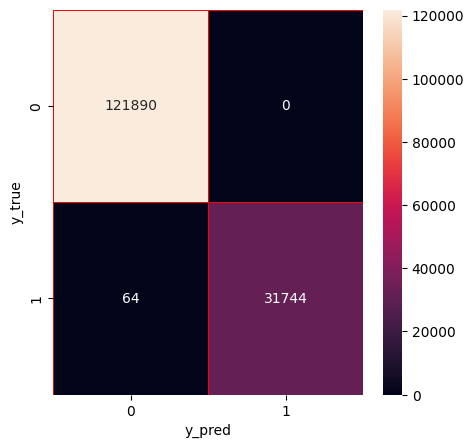

In [81]:
# Ensemble method 2: confidence-based stacking

# !!! WARNING: always update based used models below based on top_3_models in training !!!
start = time.time()
et_prob_test = et.predict_proba(X_test_fs)
rf_prob_test = rf.predict_proba(X_test_fs)
cat_prob_test = cat.predict_proba(X_test_fs)

x_test = np.concatenate([et_prob_test, rf_prob_test, cat_prob_test], axis=1)

y_predict = stk2.predict(x_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'PortScan', 'Not PortScan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of STK Confidence: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of STK Confidence: ' + str(precision))
print('Recall of STK Confidence: ' + str(recall))
print('F1-score of STK Confidence: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

Prediction time per sample:  0.013098685525402417
Accuracy of STK Hybrid: 0.9995901052713764
Precision of STK Hybrid: 0.9997417037711249
Recall of STK Hybrid: 0.9990096830985915
F1-score of STK Hybrid: 0.9993751692178892
              precision    recall  f1-score   support

Not PortScan    0.99948   1.00000   0.99974    121890
    PortScan    1.00000   0.99802   0.99901     31808

    accuracy                        0.99959    153698
   macro avg    0.99974   0.99901   0.99938    153698
weighted avg    0.99959   0.99959   0.99959    153698



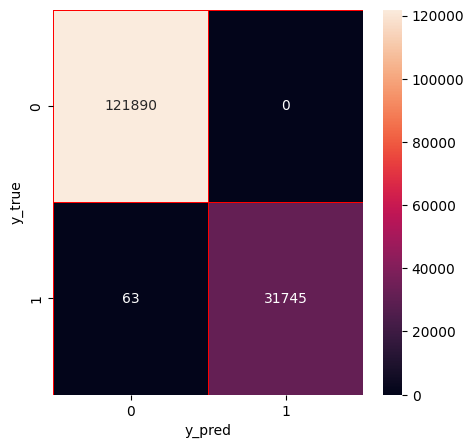

In [82]:
# Ensemble method 3: hybrid stacking

# !!! WARNING: always update based used models below based on top_3_models in training !!!
start = time.time()

et_test = et.predict(X_test_fs)
rf_test = rf.predict(X_test_fs)
cat_test = cat.predict(X_test_fs)

et_prob_test = et.predict_proba(X_test_fs)
rf_prob_test = rf.predict_proba(X_test_fs)
cat_prob_test = cat.predict_proba(X_test_fs)

et_test = et_test.reshape(-1, 1)
rf_test = rf_test.reshape(-1, 1)
cat_test = cat_test.reshape(-1, 1)

x_test = np.concatenate([et_test, rf_test, cat_test] + [et_prob_test, rf_prob_test, cat_prob_test], axis=1)

y_predict = stk3.predict(x_test)
end = time.time()
print('Prediction time per sample: ', (end - start) / len(X_test_fs)*1000)
y_predict = np.where(pd.Series(labelencoder.inverse_transform(y_predict)) == 'Portscan', 'PortScan', 'Not PortScan')

# Evaluation metrics
precision, recall, fscore, none = precision_recall_fscore_support(y_true_ps, y_predict, average='macro')

# Print results
print('Accuracy of STK Hybrid: ' + str(accuracy_score(y_true_ps, y_predict)))
print('Precision of STK Hybrid: ' + str(precision))
print('Recall of STK Hybrid: ' + str(recall))
print('F1-score of STK Hybrid: ' + str(fscore))
print(classification_report(y_true_ps, y_predict, digits=5))

# Confusion matrix visualization
cm = confusion_matrix(y_true_ps, y_predict)
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.5, linecolor="red", fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

## Inference Time

In [84]:
TRIES = 10

In [85]:
test1 = time.time()

In [86]:
test2 = time.time()

In [90]:
((test2 - test1) / 2) * 1000

2331.6069841384888

In [92]:
# this is in milliseconds, not seconds
def calculate_inference_time_in_ms(foo, tries: int):
    times = []
    for _ in range(tries):
        start = time.time()
        foo()
        end = time.time()
        times.append(((end - start) / len(X_test_fs)) * 1000)
    return np.average(times)

In [115]:
def print_time(name: str, in_ms):
    print(f"Average Inference time for {name}")
    print(in_ms, 'milliseconds')
    print(in_ms / 1000, 'seconds')
    print()

In [122]:
top_3_models

['et', 'rf', 'cat']

In [123]:
# Decision Tree
print_time("DT", calculate_inference_time_in_ms(lambda: dt.predict(X_test_fs), TRIES))

# Random Forest
print_time("RF", calculate_inference_time_in_ms(lambda: rf.predict(X_test_fs), TRIES))

# Extra Trees
print_time("ET", calculate_inference_time_in_ms(lambda: et.predict(X_test_fs), TRIES))

# XGBoost
print_time("XG", calculate_inference_time_in_ms(lambda: xg.predict(X_test_fs), TRIES))

# LightGBM
print_time("LGBM", calculate_inference_time_in_ms(lambda: lgbm.predict(X_test_fs), TRIES))

# CatBoost
print_time("Cat", calculate_inference_time_in_ms(lambda: cat.predict(X_test_fs), TRIES))

# Ensemble 1 (Change based on training's top 3 models results)
def stk1_timer():
    et_test = et.predict(X_test_fs)
    rf_test = rf.predict(X_test_fs)
    cat_test = cat.predict(X_test_fs)

    et_test = et_test.reshape(-1, 1)
    rf_test = rf_test.reshape(-1, 1)
    cat_test = cat_test.reshape(-1, 1)

    x_test = np.concatenate([et_test, rf_test, cat_test], axis=1)

    stk1.predict(x_test)

print_time("STK Traditional", calculate_inference_time_in_ms(stk1_timer, TRIES))

# Ensemble 2 (Change based on training's top 3 models results)
def stk2_timer():
    et_prob_test = et.predict_proba(X_test_fs)
    rf_prob_test = rf.predict_proba(X_test_fs)
    cat_prob_test = cat.predict_proba(X_test_fs)

    x_test = np.concatenate([et_prob_test, rf_prob_test, cat_prob_test], axis=1)

    stk2.predict(x_test)

print_time("STK Confidence", calculate_inference_time_in_ms(stk2_timer, TRIES))

# Ensemble 3 (Change based on training's top 3 models results)
def stk3_timer():
    et_test = et.predict(X_test_fs)
    rf_test = rf.predict(X_test_fs)
    cat_test = cat.predict(X_test_fs)

    et_prob_test = et.predict_proba(X_test_fs)
    rf_prob_test = rf.predict_proba(X_test_fs)
    cat_prob_test = cat.predict_proba(X_test_fs)

    et_test = et_test.reshape(-1, 1)
    rf_test = rf_test.reshape(-1, 1)
    cat_test = cat_test.reshape(-1, 1)

    x_test = np.concatenate([et_test, rf_test, cat_test] + [et_prob_test, rf_prob_test, cat_prob_test], axis=1)

    stk3.predict(x_test)

print_time("STK Hybrid", calculate_inference_time_in_ms(stk3_timer, TRIES))

Average Inference time for DT
0.00012751759486163738 milliseconds
1.2751759486163738e-07 seconds

Average Inference time for RF
0.002005488084914384 milliseconds
2.005488084914384e-06 seconds

Average Inference time for ET
0.003372454209219671 milliseconds
3.372454209219671e-06 seconds

Average Inference time for XG
0.0003892693886113267 milliseconds
3.892693886113267e-07 seconds

Average Inference time for LGBM
0.0007041937158646618 milliseconds
7.041937158646618e-07 seconds

Average Inference time for Cat
0.0002443946332856688 milliseconds
2.443946332856688e-07 seconds

Average Inference time for STK Traditional
0.006273867683771519 milliseconds
6.273867683771519e-06 seconds

Average Inference time for STK Confidence
0.006450195021119852 milliseconds
6.450195021119852e-06 seconds

Average Inference time for STK Hybrid
0.011911698452697198 milliseconds
1.1911698452697197e-05 seconds



In [118]:
et.n_estimators

147

In [119]:
rf.n_estimators

142

In [120]:
et.max_depth

38

In [121]:
rf.max_depth

26